<a target="_blank"  src="https://evophase.co.uk/"><img src="https://evophase.co.uk/wp-content/uploads/2025/10/EvoPhase_Logo_2025_7.png" style="height:200px; display: block; margin-left: auto; margin-right: auto;"/></a>


# **Interactive Example:** Learning Simulation Parameters using ACCES
#### Autonomous Characterisation and Calibration via Evolutionary Simulation

---

#### Copyright 2023-2025 The Coexist Developers.
##### Notebook authored by A. Leonard Nicusan, Co-Founder & CTO EvoPhase Ltd.

Licensed under the GNU License, Version 3.0.






## **What:** Learning simulation parameters from experimental data, from the micro to the macro, from laptops to clusters.

ACCES can calibrate **virtually any simulation parameters** against a user-defined cost function, quantifying and then minimising the “difference” between the simulated system and experimental reality – in essence, autonomously *learning* the physical properties of the system, without the need for human input.

The idea is for a given simulation to reproduce a system-specific macroscopic quantity (e.g. occupancy, residence time distribution, angle of repose). This technique is **completely agnostic to the simulation method** and the quantity to be reproduced. In a DEM context, it can train coarse-grained simulations, using larger meso-particles to model multiple smaller ones.

<br>

![Example Calibrated Image](https://coexist.readthedocs.io/en/latest/_images/calibrated.png)

*Example of an ACCES-calibrated DEM Digital Twin of a GranuTools GranuDrum; the calibration was done effectively against a single experimental data point - a photograph of the free surface shape yielded by MCC particles (left panel). The occupancy grid of a LIGGGHTS simulation was optimised against the free surface shape (right panel). The two superimposed grids amount to 4 mm² dissimilarity (dark blue pixels, middle panel).*


---

Remember that the calibration can be done for any simulation engine, and for any target(s)! The ACCES architecture works on any objective, for example:

- **Characterising** the particle properties of a DEM digital twin of an experimental instrument - GranuDrum, Shear Tester, Angle of Repose Tester, etc. Even combinations thereof!
- **Calibrating** a contact model's / drag equation's free parameters.
- **Optimising** an impeller's design while still attaining the required mixing behaviour (multi-objective!)
- **Optimising** a fluidised bed's geometry to improve its circulation - after **calibrating** CFD-DEM particle properties against some measurement, e.g. PEPT.

## **How:** Minimally-Invasive Evolutionary Optimisation

Simulations are oftentimes huge beasts that are difficult to set up and run correctly / efficiently; ask a modeller to re-write their simulation as a function (*which is what virtually all optimisers expect...*) and you might not be friends anymore.

ACCES takes a different approach: **it accepts entire simulation scripts**; 
it can take arbitrary Python code running a simulation, **automatically parallelise it** to execute efficiently on multithreaded laptops or even distributed computing clusters and deterministically optimise the user-defined free parameters. It is fault-tolerant and can return to the latest optimisation state even after e.g. a system crash.



### **Show me some code then!**

All you need to do is create a variable called `parameters` (a simple `pandas.DataFrame` table) storing the free parameters’ names and bounds, and optionally starting values and relative uncertainty. Then, by the end of the simulation script - anywhere - just define a variable named `error`, storing a number / numbers that will need to be minimised.

In [ ]:
# Install the Coexist library (takes ~15 s)
!pip install coexist

Typically, a simulation is written as a standalone script; there are no limitations on what this script does - evaluate a model, generate a LIGGGHTS / OpenFOAM parameters script, launch an external simulation, gather results, etc.

See the `minimal_simulation_script.py` file for an example of such a script - we'll run it in the next code cell:

In [2]:
%run minimal_simulation_script.py

CoR / CED / Epsilon / Mu: 0.5 1.2 1.5 4.2
For these parameters, the error is 123.10610000000001


---
This is an example of a script written by an engineer running a simulation - it has some free `parameters` that we want to tune such that the `error` is minimised.

To let ACCES do this autonomously, all we need to do is declare those `parameters` at the top of the script, give them some names and possible ranges of values they can take. See the `access_simulation_script.py` file now - once those `parameters` are declared, the script is executed exactly as before:

In [3]:
%run access_simulation_script.py

ACCES parameters declared:
          value  min  max  sigma
CoR        0.0 -5.0  5.0    4.0
CED        0.0 -5.0  5.0    4.0
Epsilon    0.0 -5.0  5.0    4.0
Mu         0.0 -5.0  5.0    4.0 

For these parameters, the error is 170.0


---

If a single simulation runs well, then you can pass it to ACCES to optimise the `error`. Executing the code cell below, you can let ACCES calibrate the `parameters`.

*You can also interrupt the code cell, check intermediate results (run the next code cells further down), then relaunch ACCES - it will pick up from where it left off!*

In [4]:
# Use ACCES to learn a simulation's parameters
import coexist

access = coexist.Access("access_simulation_script.py")
access.learn(
    num_solutions = 8,          # Number of solutions per epoch
    target_sigma = 0.05,        # Target std-dev (accuracy) of solution
    random_seed = 42,           # Reproducible / deterministic optimisation
);


Starting ACCES run at 23:59:27 on 11/06/2023 in directory `access_seed42`.
Epoch    0 | Population    8 | Time 23:59:27
--------------------------------------------------------------------------------
Scaled overall standard deviation: 1.0
                  CoR       CED   Epsilon        Mu
estimate     0.000000  0.000000  0.000000  0.000000
uncertainty  3.333333  3.333333  3.333333  3.333333
scaled_std   0.833333  0.833333  0.833333  0.833333

        CoR       CED   Epsilon        Mu      error0       error
0  1.015724 -3.466614  2.501504  3.135216  224.738517  224.738517
1 -4.396549 -4.340598  0.426135 -1.054142   70.880077   70.880077
2 -0.056004 -2.843480  2.931327  2.592640  200.214587  200.214587
3  0.220102  3.757471  1.558364 -2.864308  101.147559  101.147559
4  1.229169 -3.196275  2.928168 -0.166420  180.193625  180.193625
5 -0.616208 -2.269765  4.075138 -0.515098  170.127509  170.127509
6 -1.427759 -1.173779  1.774364  1.218147  154.587917  154.587917
7  1.375775  1.436070 

The analytical global optimum is $-25$; we got to $-24.97$ within 256 trials.

Take a moment to appreciate what we’ve done here: out of 8 global and 2 local - false - minima, we have found an optimum 4-dimensional parameter combination with only 256 function evaluations. Compare that with a classical approach of regular sampling on a 10x10x10x10 grid - we used 30 times fewer "simulations", yet we found an optimum within 0.32% of the analytical solution!

### Checking (Intermediate) Results

Each ACCES run creates a folder `access_seed<random_seed>` saving the optimisation state. You can access (pun intended) it using `coexist.AccessData()`, even while the optimisation is still running for intermediate results:

In [5]:
import coexist

access_data = coexist.AccessData("access_seed42")
access_data

AccessData
--------------------------------------------------------------------------------
paths             ╎ AccessPaths(...)
parameters        ╎             value  min  max     sigma
                  ╎ CoR      3.009703 -5.0  5.0  0.074631
                  ╎ CED      2.002950 -5.0  5.0  0.071116
                  ╎ Epsilon  4.999993 -5.0  5.0  0.229003
                  ╎ Mu      -4.995822 -5.0  5.0  0.183462
parameters_scaled ╎             value   min   max     sigma
                  ╎ CoR      0.752426 -1.25  1.25  0.018658
                  ╎ CED      0.500738 -1.25  1.25  0.017779
                  ╎ Epsilon  1.249998 -1.25  1.25  0.057251
                  ╎ Mu      -1.248955 -1.25  1.25  0.045866
scaling           ╎ [4. 4. 4. 4.]
population        ╎ 8
num_epochs        ╎ 32
target            ╎ 0.05
seed              ╎ 42
epochs            ╎ DataFrame(CoR_mean, CED_mean, Epsilon_mean, Mu_mean,
                  ╎           CoR_std, CED_std, Epsilon_std, Mu_std, overall_std)

You can create a “convergence plot” showing the evolution of the ACCES run using `coexist.plots.access` - this can be done even while 2-weeks long simulations run to check intermediate results:

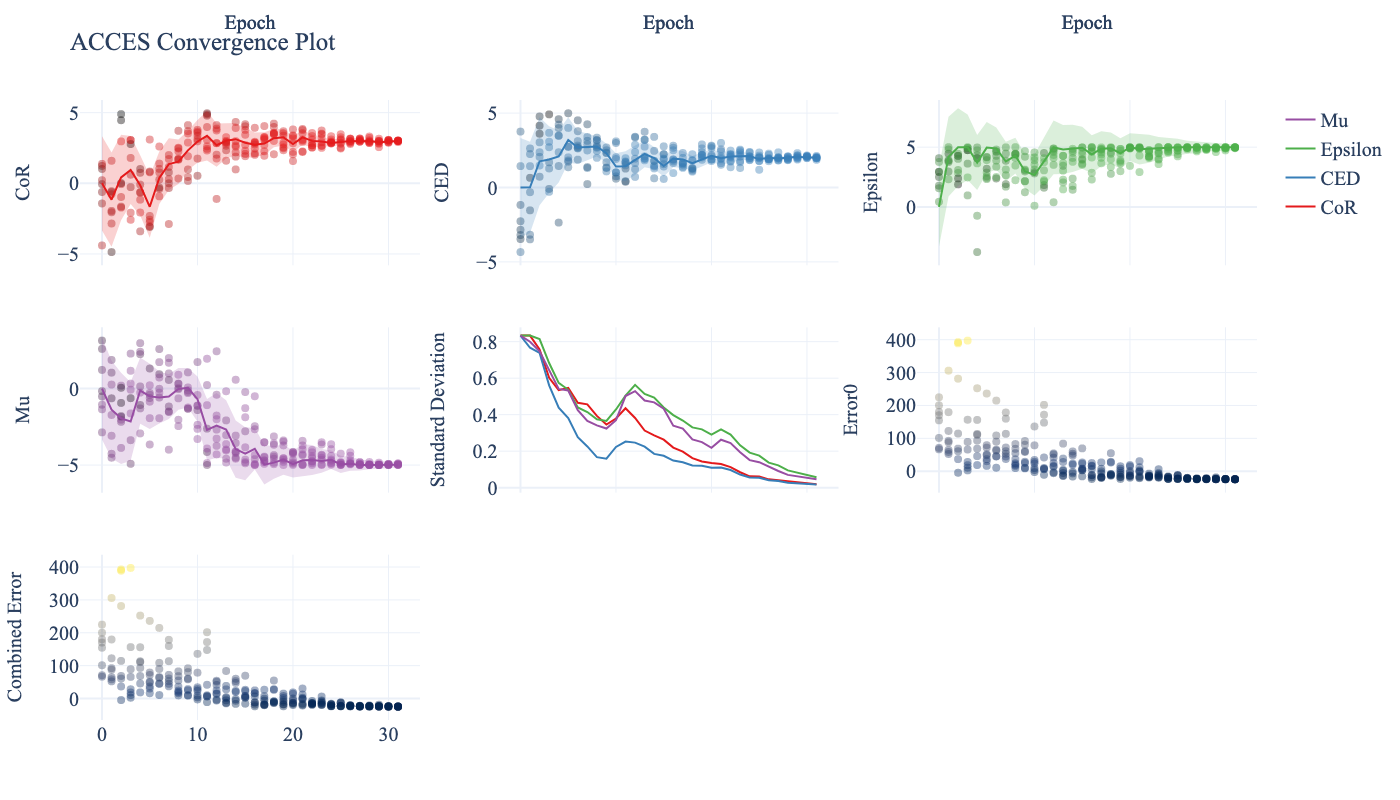

In [6]:
# Set plots' renderer - e.g. "iframe", "browser", "pdf", "png"
import plotly
plotly.io.renderers.default = "png"

coexist.plots.access("access_seed42").show(width=1400, height=800)

If you zoom into the error value, you’ll see that ACCES effectively found the optimum in less than 15 epochs; while this particular error function is smooth and a gradient-based optimiser may be quicker if the initial guess is close to a global optimum, this can never be assumed with physical simulations and noisy measurements (see the image at the top of the page).

You can visualise 2D slices through the parameter space explored, colour-coded by the error value of the closest parameter combination tried:

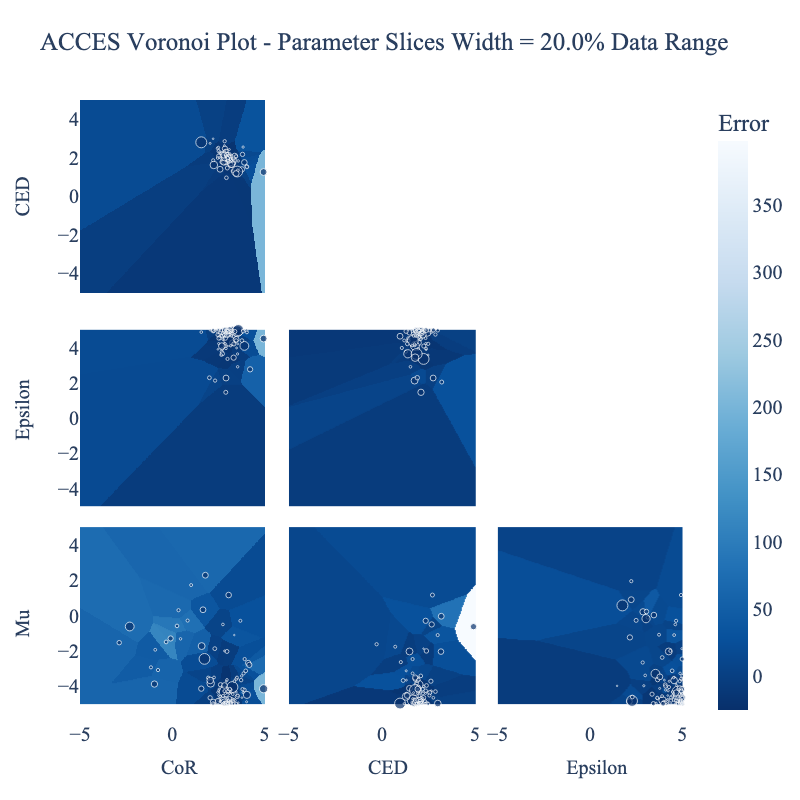

In [7]:
coexist.plots.access2d("access_seed42").show(width=800, height=800)

The circles are the parameter combinations tried; the cells’ colours represent the closest simulation’s error value (darker = smaller). The smaller the cell, the more simulations were run in that region - notice how ACCES spends minimum computational time on unimportant, high-error areas and more around the global optimum.

## Multi-Objective Optimisation

We often want to optimise multiple targets at the same time, for example:

- Characterising complex particle behaviour across different flow states (e.g. GranuDrum at 15rpm and 45rpm, at the same time).
- Optimise an impeller's design by minimising energy consumption while also maximising mixing quality.

The ACCES library comes with a suite of objective *combiners* that join multiple error values into a single, combined one. 

To use it, simply define the `error` variable as a list of multiple values - check the `multi_objective_simulation_script.py` file for an example of a difficult nonlinear 2D problem, where the two errors depict strong tradeoffs: when one is minimised, the other becomes large.

Again, we can run the script on its own as you'd launch a standalone simulation:

In [8]:
%run multi_objective_simulation_script.py

   value       min       max     sigma
x    0.0 -3.141593  3.141593  2.513274
y    0.0 -3.141593  3.141593  2.513274
For these parameters, the errors are [-25.763009244007502, -10.0]


It works, now let ACCES optimise our parameters!

In [9]:
# Use ACCESS to learn a simulation's parameters
import coexist

coexist.Access("multi_objective_simulation_script.py").learn(
    num_solutions = 8,
    target_sigma = 0.05,
    random_seed = 420,
);


Starting ACCES run at 00:01:05 on 12/06/2023 in directory `access_seed420`.
Epoch    0 | Population    8 | Time 00:01:05
--------------------------------------------------------------------------------
Scaled overall standard deviation: 1.0
                    x         y
estimate     0.000000  0.000000
uncertainty  2.094395  2.094395
scaled_std   0.833333  0.833333

          x         y     error0     error1       error
0 -0.930896 -2.531556 -15.912791  -6.626856  105.451775
1 -3.140390 -0.826354  -4.231734  -0.049862    0.211004
2  0.733962  0.063588 -13.919329 -15.073689  209.815631
3  0.633913 -3.095404  -1.690023 -17.596043   29.737714
4  2.679886 -1.007508  -2.864985 -32.261156   92.427737
5  2.228332 -0.595178  -2.492769 -27.499342   68.549500
6 -0.664128 -1.494147 -37.293232  -5.700480  212.589307
7  2.024446  2.116646 -13.654981 -34.958538  477.358161
Total function evaluations: 8

Epoch    1 | Population    8 | Time 00:01:09 | Since Last 00:03
------------------------------

The analytical optimum is $0$; we got to $0.0027$ within 15 epochs - and we've **optimised two highly nonlinear objectives simultaneously with only 120 trials**! Let's check how ACCES converged onto the parameter values that optimise both errors:

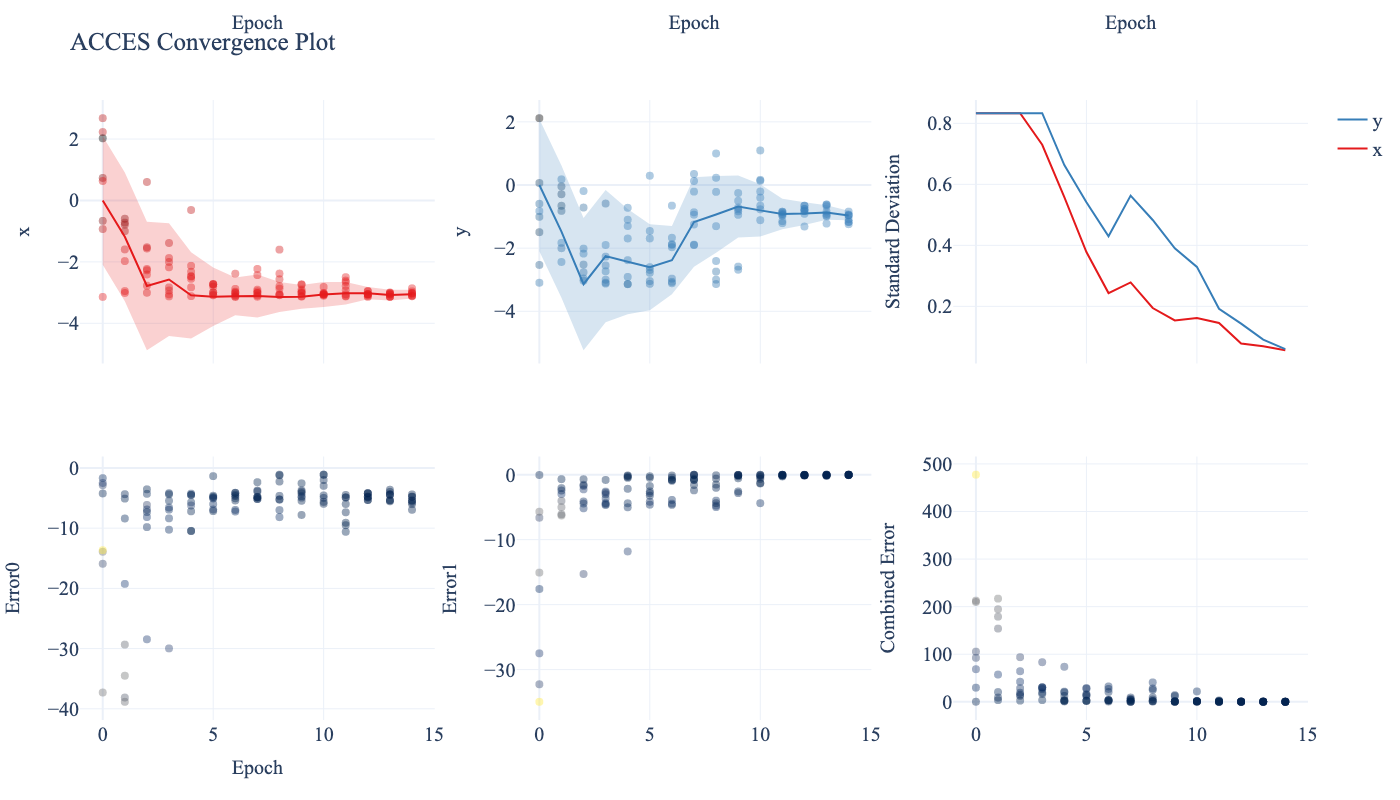

In [10]:
coexist.plots.access("access_seed420").show(width=1400, height=800)

The two errors are colour-coded by their resulting combined error value - notice how when `Error0` is minimised, the coloured points are brighter, signifying a large total error. The **global optimum** is achieved by balancing both errors at the same time - which ACCES does elegantly.

Finally, let's see how the possible parameter space has been explored:

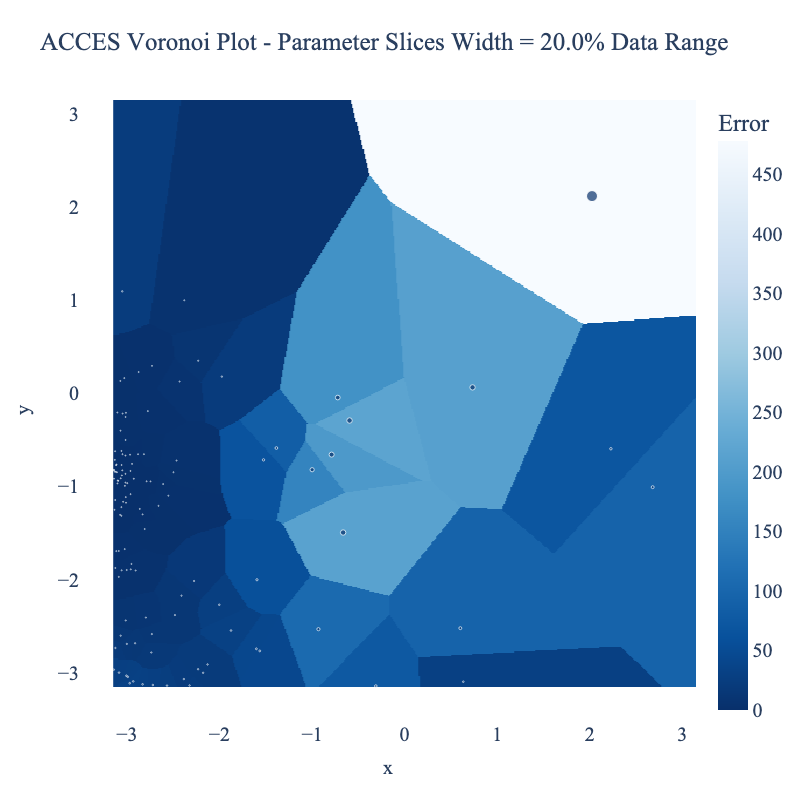

In [11]:
coexist.plots.access2d("access_seed420").show(width=800, height=800)